In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')


import unicodedata
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import itertools
from scipy import stats
from scipy.spatial.distance import pdist, squareform 
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib
from IPython.display import HTML, display
from sklearn.decomposition import NMF

In [2]:
df = pd.read_json('../data/lyrics_cleaned.json')

In [3]:
df.reset_index(drop=True, inplace=True)

In [4]:
# let's check out a random song
idx = np.random.randint(0,6252)
print(df.iloc[idx, 0], '-', df.iloc[idx, 1], '\n', 
      '--------------',
      '\n', df.iloc[idx, 2])

Ciara Featuring Ludacris - Ride 
 -------------- 
 (feat. Ludacris)  [Ciara:]  Uh-huh   [Intro:]  Catch me in the mall  You know I buy it out.  G5 planes, yeah I fly it out.  N-gga in the back look like lex  In them 28's and  Oh you can't get her if  Ain't got plenty cake.  ATL Georgia, bodies  Look like this size  23 waist, pretty face  Thick thighs.  [Ciara:]  I can do it big  I can do it long  I can do whenever or however  You want  I can do it up and down  I can do circles  To him I'm a gymnast  This one is my circus  [Chorus:]  I mark it so good  They can't wait til you try  Me  I work it so good  Man, these n-ggas  Tryna buy I I I I me  They love they way I ride it [x3]  They love the way I ride the beat  How I ride the beat, I ride it  They love they way I ride it [x3]  They love the way I ride the beat  Like a motherf-cking freak  And I won't stop, don't stop  Get it! Get it!  I'm a pitch down the middle  Baby hit it! hit it!  I do it tonight  Handle my business, like a big gir

In [155]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X = vectorizer.fit_transform(df['lyrics'])
features = vectorizer.get_feature_names()

In [163]:
word_idfs_dict = {}
for word, idf in zip(vectorizer.vocabulary_, vectorizer.idf_):
    word_idfs_dict[word] = idf

In [171]:
gt_7 = {}
ls_5 = {}
for k, v in word_idfs_dict.items():
    if v > 7:
        gt_7[k] = v
    if v < 5:
        ls_5[k] = v

In [173]:
# idf greater than 7: sometimes informative but usually not
gt_7

{'shit': 7.101759297952039,
 'nike': 7.101759297952039,
 'gotta': 9.047669447007353,
 'ma': 8.131378715133199,
 'left': 7.101759297952039,
 'don': 7.2559099777792975,
 'michael': 7.032766426465088,
 'jackson': 7.794906478511985,
 'action': 7.661375085887462,
 'girl': 7.101759297952039,
 'everyday': 7.175867270105761,
 'shorties': 7.2559099777792975,
 'knot': 7.2559099777792975,
 'shooters': 7.175867270105761,
 'long': 7.2559099777792975,
 'wrong': 7.661375085887462,
 'got': 7.175867270105761,
 'pop': 7.949057158339243,
 'love': 7.794906478511985,
 'family': 7.175867270105761,
 'think': 7.101759297952039,
 'open': 7.032766426465088,
 'lick': 7.032766426465088,
 'damn': 7.032766426465088,
 'trappin': 7.101759297952039,
 '80s': 7.661375085887462,
 'cash': 7.543592050231078,
 'sell': 7.2559099777792975,
 'wet': 7.543592050231078,
 'stash': 8.642204338899187,
 'try': 7.101759297952039,
 'll': 8.131378715133199,
 'lay': 9.047669447007353,
 'ass': 7.543592050231078,
 'son': 7.032766426465088,

In [175]:
# idf less than 5: again, sometimes informative but usually not
ls_5

{'leather': 4.9367955828340415,
 'want': 4.622822815150543,
 'mean': 4.020504850959886,
 'just': 4.8504674993455446,
 'em': 4.365538219883133,
 'pour': 4.0139688799801005,
 'seal': 4.835541849128868,
 'wipe': 2.004072945113802,
 'nose': 4.483321255539517,
 'say': 3.9207336972149363,
 'draco': 4.264353075635787,
 'ballin': 3.7344634679655653,
 'bitch': 4.8887863636476805,
 'hahaha': 4.703864025153669,
 'took': 4.388958494091232,
 'president': 3.9787652447871213,
 'change': 3.5443724997727775,
 'maybe': 4.771003327991298,
 'scary': 3.2455510716302896,
 'hurt': 4.912502890264997,
 'didn': 2.608319075907254,
 'coming': 4.710378706174863,
 'chasin': 4.987226436460933,
 'scream': 4.113195513876661,
 'babe': 1.8641781665918353,
 'prolly': 3.0725883791498947,
 'steal': 4.442499261019261,
 'beating': 4.320281628295012,
 'mad': 4.945026081970557,
 'hey': 4.92863227219488,
 'upside': 4.6973915106480515,
 'cold': 4.243648402274096,
 'shower': 3.441867380711355,
 'kitchen': 4.131344832382338,
 'sur

In [161]:
vectorizer.vocabulary_

5000

In [162]:
vectorizer.idf_

5000

In [47]:
kmeans = KMeans(n_clusters=6)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [48]:
top_centroids = kmeans.cluster_centers_.argsort()[:,-1:-11:-1]
print("\n3) top features (words) for each cluster:")
for num, centroid in enumerate(top_centroids):
    print("%d: %s" % (num, ", ".join(features[i] for i in centroid)))


3) top features (words) for each cluster:
0: don, baby, know, wanna, just, want, ll, like, let, girl
1: like, just, ll, ve, yeah, know, got, love, time, don
2: like, nigga, got, yeah, bitch, ain, shit, fuck, ya, niggas
3: oh, yeah, baby, like, know, love, don, want, let, ooh
4: love, baby, know, ll, don, heart, just, way, need, like
5: la, love, like, baby, don, lala, oh, just, ooh, cause


**Not really useful outputs. Contractions are being split and shouldn't be. Too many words are common across all found topics. Need to adjust the stopwords a bit. Might find some value in increasing n-grams.**

In [8]:
vectorizer = TfidfVectorizer(stop_words='english', 
                             max_features=10000)
X = vectorizer.fit_transform(df['lyrics'])
features = vectorizer.get_feature_names()

In [9]:
top_idxs = np.argsort(vectorizer.idf_)[::-1]
bottom_idxs = np.argsort(vectorizer.idf_)[::]

In [10]:
features = vectorizer.get_feature_names()

In [11]:
bottom_100_words = [features[i] for i in bottom_idxs[:100]]

In [12]:
bottom_100_words

['know',
 'just',
 'like',
 'don',
 'got',
 'love',
 'll',
 'cause',
 'let',
 'time',
 'yeah',
 'baby',
 'make',
 'say',
 'oh',
 'way',
 'right',
 'want',
 'ain',
 'come',
 'wanna',
 've',
 'girl',
 'tell',
 'need',
 'feel',
 'think',
 'life',
 'night',
 'man',
 'good',
 'gonna',
 'look',
 'heart',
 'said',
 'day',
 'little',
 'gotta',
 'world',
 'away',
 'won',
 'mind',
 'chorus',
 'eyes',
 'ya',
 'long',
 'things',
 'thing',
 'better',
 'really',
 'hold',
 'home',
 'leave',
 'real',
 'shit',
 'stop',
 'em',
 'head',
 'turn',
 'hard',
 'hit',
 'stay',
 'boy',
 'hey',
 'new',
 'money',
 'bout',
 'did',
 'try',
 'gone',
 'hear',
 'left',
 'face',
 'play',
 'nigga',
 'tonight',
 'big',
 'fuck',
 'thought',
 'believe',
 'bad',
 'run',
 'told',
 'talk',
 'wrong',
 'gon',
 'live',
 'high',
 'going',
 'bitch',
 'inside',
 'crazy',
 'old',
 'yo',
 'break',
 'hand',
 'came',
 'feeling',
 'walk',
 'fall']

In [13]:
from nltk.corpus import stopwords
lyric_stopwords = set(stopwords.words('english') + bottom_100_words)

In [14]:
vectorizer = TfidfVectorizer(stop_words=list(lyric_stopwords), 
                             max_features=5000, 
                             ngram_range=(2,5))
X = vectorizer.fit_transform(df['lyrics'])
features = vectorizer.get_feature_names()

In [24]:
def fit_nmf(r, data):
    nmf = NMF(n_components=r, init='random', random_state=0)
    nmf.fit(data)
    W = nmf.transform(data)
    H = nmf.components_
    return nmf.reconstruction_err_

Text(0, 0.5, 'Reconstruction Errror')

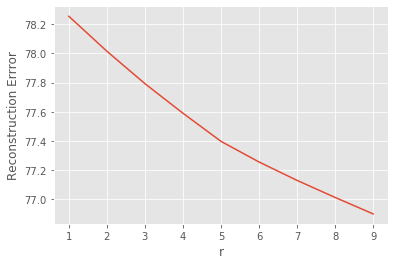

In [16]:
range_size = range(1, 10)
error = [fit_nmf(i, X) for i in range_size]
plt.plot(range_size, error)
plt.xticks(range_size)
plt.xlabel('r')
plt.ylabel('Reconstruction Errror')

Starting to see an elbow at n_components=5 with n_grams ranging from 2-10. But the reconstruction error is still really high.

**Try just looking at few artists at first**

In [127]:
df.groupby('artist').count().sort_values(by='title', ascending=False).head(30)

,title,lyrics,character_count,word_count
artist,,,,
Taylor Swift,58,58,58,58
Kenny Chesney,42,42,42,42
Tim McGraw,39,39,39,39
Keith Urban,37,37,37,37
Drake,33,33,33,33
Rascal Flatts,32,32,32,32
Brad Paisley,32,32,32,32
George Strait,30,30,30,30
Toby Keith,30,30,30,30


In [17]:
eminem_chesney = df[(df['artist'] == 'Eminem') | (df['artist'] == 'Kenny Chesney')]

In [18]:
eminem_chesney

,artist,title,lyrics,character_count,word_count
65,Kenny Chesney,Here And Now,Seen the skyline of New York City Fireflies i...,1642,309
84,Eminem,Darkness,"I don't wanna be alone, I don't wanna be I do...",4793,896
114,Eminem,Premonition (Intro),"Yeah So I guess this is what it is, huh? Thi...",2865,576
117,Eminem,In Too Deep,"""This could never work,"" is what we said at fi...",2984,568
124,Eminem,Marsh,"My name is Marsh and this world, I'm out of it...",4139,775
...,...,...,...,...,...
5147,Kenny Chesney,She Thinks My Tractor's Sexy,(Paul Overstreet/Jim Collins) Plowin' these f...,1710,327
5182,Kenny Chesney,You Had Me From Hello,"(Kenny Chesney/Skip Ewing) One word, that's a...",1185,241
5258,Kenny Chesney,How Forever Feels,(Tony Mullins/Wendell Mobley) Big orange ball...,1077,197
5339,Eminem,My Name Is,"Hi, my name is, what? My name is, who? My nam...",3963,778


In [65]:
vectorizer = TfidfVectorizer(stop_words='english', 
                             max_features=5000, 
                             ngram_range=(1,3))
X = vectorizer.fit_transform(eminem_chesney['lyrics'])
features = vectorizer.get_feature_names()

Text(0, 0.5, 'Reconstruction Errror')

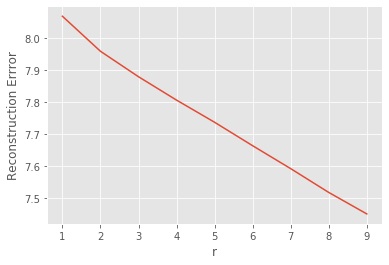

In [66]:
range_size = range(1, 10)
error = [fit_nmf(i, X) for i in range_size]
plt.plot(range_size, error)
plt.xticks(range_size)
plt.xlabel('r')
plt.ylabel('Reconstruction Errror')

In [78]:
model = NMF(n_components=2, init='random', random_state=0)
W = model.fit_transform(X)
H = model.components_

In [79]:
model.reconstruction_err_

7.958975664685379

In [69]:
def hand_label_topics(H, vocabulary):
    '''
    Print the most influential words of each latent topic, and prompt the user
    to label each topic. The user should use their humanness to figure out what
    each latent topic is capturing.
    '''
    hand_labels = []
    for i, row in enumerate(H):
        top_five = np.argsort(row)[::-1][:10]
        print('topic', i)
        print('-->', ' '.join(vocabulary[top_five]))
#         label = input('please label this topic: ')
#         hand_labels.append(label)
#         print()
    return hand_labels

In [80]:
features = np.array(features)
hand_label_topics(H, features)

topic 0
--> meant mama closet cleanin meant hurt meant meant make mama meant hurt mama meant sorry mama meant tonight cleanin closet
topic 1
--> like just cause don ll know got say said yeah


[]

In [94]:
import pprint as pp

In [100]:
df[(df['artist'] == 'Eminem')]

,artist,title,lyrics,character_count,word_count
84,Eminem,Darkness,"I don't wanna be alone, I don't wanna be I do...",4793,896
114,Eminem,Premonition (Intro),"Yeah So I guess this is what it is, huh? Thi...",2865,576
117,Eminem,In Too Deep,"""This could never work,"" is what we said at fi...",2984,568
124,Eminem,Marsh,"My name is Marsh and this world, I'm out of it...",4139,775
131,Eminem,Stepdad,"Hey, yo (This song's about) My, my stepdad ...",3323,636
384,Eminem,Venom,I got a song filled with shit for the strong w...,4668,867
388,Eminem,Killshot,"You sound like a bitch, bitch Shut the fuck u...",5231,1002
1520,Eminem,Rap God,"Look, I was gonna go easy on you not to hurt y...",8122,1539
1557,Eminem,Berzerk,"Now this sht's about to kick off, this party ...",3588,679
1585,Eminem,Survival,[Hook: Liz Rodrigues] This is survival of the...,3904,781


In [102]:
print(df['lyrics'][3753])

Yeah  I know sometimes things may not always make sense to you right now  But hey, what daddy always tell you?   Straighten up little soldier  Stiffen up that upper lip  What you crying about?  You got me    Hailie I know you miss your mom and I know you miss your dad  When I'm gone but I'm trying to give you the life that I never had  I can see you're sad, even when you smile, even when you laugh  I can see it in your eyes, deep inside you want to cry  Cuz you're scared, I ain't there?  Daddy's with you in your prayers  No more crying, wipe them tears  Daddy's here, no more nightmares  We gon' pull together through it, we gon' do it  Laney uncles crazy, aint he?  Yeah but he loves you girl and you better know it  We're all we got in this world  When it spins, when it swirls  When it whirls, when it twirls  Two little beautiful girls  Lookin' puzzled, in a daze  I know it's confusing you  Daddy's always on the move, mamma's always on the news  I try to keep you sheltered from it but so

In [104]:
df[(df['artist'] == 'Kenny Chesney')]

,artist,title,lyrics,character_count,word_count
65,Kenny Chesney,Here And Now,Seen the skyline of New York City Fireflies i...,1642,309
172,Kenny Chesney,Tip Of My Tongue,I love the dimples in the small of your back ...,1436,310
416,Kenny Chesney,Get Along,"Met a man wearing a T-shirt, said ""Virginia is...",1553,312
642,Kenny Chesney,All The Pretty Girls,All the pretty girls said pick me up at eight ...,1577,302
1010,Kenny Chesney,Noise,"Wrecking balls, downtown construction Bottles...",1540,281
1123,Kenny Chesney,Save It For A Rainy Day,It's no secret that lately there ain't no esca...,1705,340
1294,Kenny Chesney,Til It's Gone,"Got nowhere to go, all night to get there But...",1539,303
1353,Kenny Chesney,American Kids,Doublewide Quick Stop midnight T-top Jack in h...,1826,338
1663,Kenny Chesney,When I See This Bar,"Well I see the souls of so many friends, And ...",1729,344
1693,Kenny Chesney,Pirate Flag,"Well I come from a little bitty, homegrown sma...",1707,338


In [103]:
df['lyrics'][4033]

"All he could think about was I'm too young for this.  Got my whole life ahead.  Hell I'm just a kid myself.   How'm I gonna raise one.  All he could see were his dreams goin' up in smoke.  So much for ditchin' this town and hangin' out on the coast.  Oh well, those plans are long gone.    And he said,  There goes my life.  There goes my future, my everything.  Might as well kiss it all good-bye.  There goes my life.......    A couple years of up all night and a few thousand diapers later.  That mistake he thought he made covers up the refrigerator.  Oh yeah..........he loves that little girl.    Momma's waiting to tuck her in,  As she fumbles up those stairs.  She smiles back at him dragging that teddy bear.  Sleep tight, blue eyes and bouncin' curls.    He smiles.....  There goes my life.  There goes my future, my everything.  I love you, daddy good-night.  There goes my life.    She had that Honda loaded down.  With Abercrombie clothes and 15 pairs of shoes and his American Express.

**Drake and Rascal Flats**

In [146]:
drake_rascal = df[(df['artist'] == 'Drake') | (df['artist'] == 'Rascal Flats')]

In [151]:
vectorizer = TfidfVectorizer(stop_words='english', 
                             max_features=5000, 
                             ngram_range=(1,6))
X = vectorizer.fit_transform(drake_rascal['lyrics'])
features = vectorizer.get_feature_names()

Text(0, 0.5, 'Reconstruction Errror')

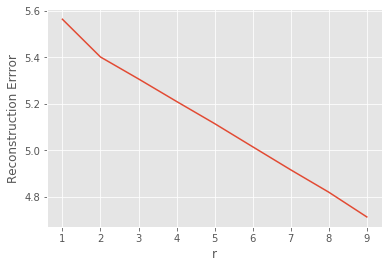

In [152]:
range_size = range(1, 10)
error = [fit_nmf(i, X) for i in range_size]
plt.plot(range_size, error)
plt.xticks(range_size)
plt.xlabel('r')
plt.ylabel('Reconstruction Errror')

In [153]:
model = NMF(n_components=2, init='random', random_state=0)
W = model.fit_transform(X)
H = model.components_

In [154]:
features = np.array(features)
hand_label_topics(H, features)

topic 0
--> passin old things say say passin passive away passive fallin fallin apart passionate miles away passive things away passive things away passive things say
topic 1
--> know like got shit yeah nigga niggas don make just


[]

## Let's build a vectorizer from scratch!

In [ ]:
def lyric_tokenizer():
    

In [43]:
from nltk.util import ngrams
from nl
def get_word_list(text):
    result = text.lower().split()
    # square brackets signify who is speaking/singing
    result = [w for w in result if (w.startswith('[') and w.endswith(']')) != True]
    
    return result

In [44]:
# text = df.iloc[np.random.randint(0,6252), 2]

In [45]:
get_word_list(text)

['uh',
 'huh',
 'yea,',
 'yeah',
 'duro!',
 'you',
 'gotta',
 'let',
 'it',
 'bump',
 'uh,',
 'uh,',
 'uh',
 'like',
 'dat',
 'yeah',
 'come',
 'on',
 'bring',
 'the',
 'chorus',
 'in',
 '1',
 '-',
 "i'd",
 'risk',
 'everything',
 'for',
 'one',
 'kiss,',
 'everything',
 'yes',
 "i'd",
 'do',
 'anything',
 '(anything?)',
 'anything',
 'for',
 'you',
 "i'd",
 'do',
 'a',
 'bid,',
 'loose',
 'a',
 'rib,',
 'bust',
 'a',
 'cap,',
 "trustin'",
 'that',
 'run',
 'up',
 'to',
 'heaven',
 'doors,',
 'exchange',
 'my',
 'life',
 'for',
 'yours',
 'leave',
 'a',
 'steak',
 'out',
 'the',
 'door,',
 'mi',
 'casa,',
 'su',
 'casa',
 'just',
 'remember',
 'to',
 'turn',
 'the',
 'lights',
 'off',
 'in',
 'the',
 'hall',
 'my',
 'brother',
 'from',
 'anotha',
 'pop,',
 'minus',
 'one',
 'shot',
 'we',
 'neno',
 'and',
 'g-money',
 'man,',
 'we',
 'all',
 'we',
 'got',
 'from',
 'the',
 'stoop',
 'to',
 'the',
 'big',
 'dudes,',
 "stoppin'",
 'us',
 'from',
 "playin'",
 'hoops',
 'and',
 'us',
 'get